In [1]:
import os
import numpy as np
os.chdir('/import/home2/yhchenmath/Code/ucs/')
# No warning
import warnings
import tifffile
import h5py
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn
warnings.filterwarnings('ignore')
from downstream.utils import read_json_to_namespace

config = read_json_to_namespace("./downstream/config/xenium_breast_cancer.json")

In [2]:
from downstream import portal

2024-04-30 23:45:51.574316: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
ad_st = sc.read_h5ad(f"{config.output_dir}/scVI_output/Cell_10X/annotated_adata_st.h5ad")
ad_sc = sc.read_h5ad(f"{config.output_dir}/scVI_output/Cell_10X/adata.h5ad")
# Tech = sc
ad_sc = ad_sc[ad_sc.obs["tech"] == "sc"]

In [4]:
# To count
ad_st.X = ad_st.layers["counts"]
ad_sc.X = ad_sc.layers["counts"]

In [5]:
model = portal.Model()

In [6]:
model.preprocess(ad_st, ad_sc)

Normalizing and scaling...
Dimensionality reduction via PCA...


In [7]:
model.train()

Begining time:  Tue Apr 30 23:46:05 2024
step 0, loss_D=7.316596, loss_GAN=2.839954, loss_AE=99.032402, loss_cos=38.775497, loss_LA=70.913933
step 200, loss_D=2.110388, loss_GAN=2.342295, loss_AE=6.803496, loss_cos=3.104211, loss_LA=1.465160
step 400, loss_D=2.143324, loss_GAN=2.369724, loss_AE=4.507380, loss_cos=2.227847, loss_LA=0.805984
step 600, loss_D=2.287066, loss_GAN=2.369478, loss_AE=4.118804, loss_cos=2.253620, loss_LA=0.641459
step 800, loss_D=2.249525, loss_GAN=2.440751, loss_AE=3.772195, loss_cos=2.115775, loss_LA=0.488023
step 1000, loss_D=2.043550, loss_GAN=2.652236, loss_AE=3.516609, loss_cos=1.939035, loss_LA=0.421313
step 1200, loss_D=2.207942, loss_GAN=2.528548, loss_AE=3.458422, loss_cos=1.974790, loss_LA=0.375051
step 1400, loss_D=2.317759, loss_GAN=2.616223, loss_AE=3.552224, loss_cos=1.915609, loss_LA=0.339193
step 1600, loss_D=2.173097, loss_GAN=2.529609, loss_AE=3.209887, loss_cos=1.868041, loss_LA=0.311458
step 1800, loss_D=2.307382, loss_GAN=2.651023, loss_AE

In [8]:
model.eval() # get integrated latent representation of cells

Begining time:  Tue Apr 30 23:47:03 2024
Ending time:  Tue Apr 30 23:47:03 2024
Evaluating takes 0.09 seconds


In [9]:
integrated_data = model.latent

In [11]:
label_st = portal.annotate_by_nn(vec_tar=integrated_data[:ad_st.shape[0]], vec_ref=integrated_data[ad_st.shape[0]:], label_ref=ad_sc.obs["C_scANVI"].values, metric='euclidean')

In [13]:
ad_st.obs["C_portal"] = label_st
ad_sc.obs["C_portal"] = ad_sc.obs["C_scANVI"]

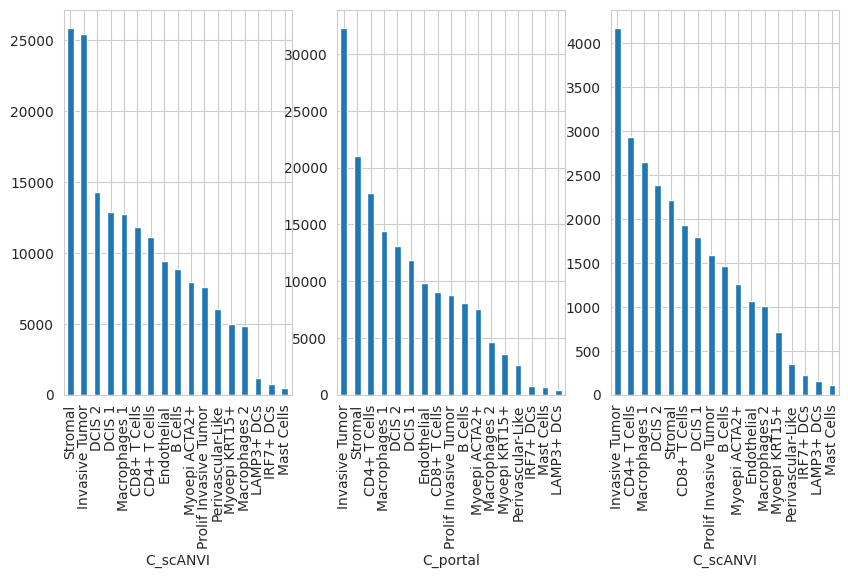

In [14]:
# Plot cell number
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ad_st.obs["C_scANVI"].value_counts().plot(kind="bar", ax=ax[0])
ad_st.obs["C_portal"].value_counts().plot(kind="bar", ax=ax[1])
ad_sc.obs["C_scANVI"].value_counts().plot(kind="bar", ax=ax[2])
plt.show()

In [15]:
# SCRNA
ad_sc = sc.read_h5ad(f"{config.output_dir}/scVI_output/UCS_10X/adata.h5ad")
# Tech = sc
ad_sc = ad_sc[ad_sc.obs["tech"] == "sc"]
sc.pp.scale(ad_sc, max_value=10)
sc.tl.pca(ad_sc, n_comps=20)
pcs = ad_sc.varm['PCs']
ad_sc.obs["C_portal"] = ad_sc.obs["C_scANVI"]

In [16]:
ad_sc = sc.read_h5ad(f"{config.output_dir}/scVI_output/Cell_10X/adata.h5ad")
# Tech = sc
ad_sc = ad_sc[ad_sc.obs["tech"] == "sc"]

In [17]:
# Load other
he = tifffile.imread(config.he)
dapi = tifffile.imread(config.dapi)

gene_map = tifffile.imread(config.gene_map)
gene_map_sum = gene_map.sum(axis=2)
with open(config.gene_names, 'r') as f:
    gene_names = f.readlines()
gene_names = [x.strip() for x in gene_names]

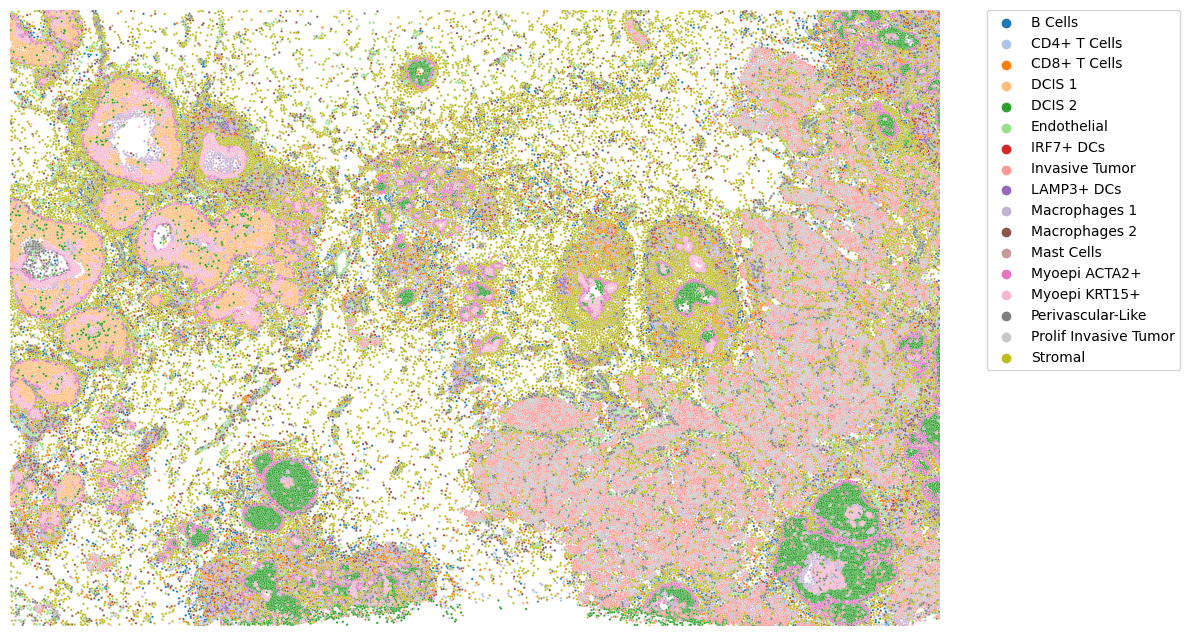

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
# reset style
plt.style.use('default')
plt.figure(figsize=(12, 8))
plt.ylim(0, gene_map.shape[0])
plt.xlim(gene_map.shape[1], 0)
# Sorted by cell type
annotated_adata_st = ad_st
plot_df = pd.DataFrame(annotated_adata_st.obsm['spatial'], columns=['center_x', 'center_y'])
plot_df['C_scANVI'] = annotated_adata_st.obs['C_scANVI'].values
plot_df = plot_df.sort_values(by='C_scANVI')
# Selected Endothelial and invasive Tumor / Prolif Invasive Tumor
# plot_df = plot_df[plot_df['C_scANVI'].isin(["DCIS 1", "DCIS 2", "Invasive Tumor", "Prolif Invasive Tumor", "T Cell & Tumor Hybrid", "Myoepi ACTA2+", "Myoepi KRT15+"])]
# Change color
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=3 , palette='tab20')
# Legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# No axis
plt.axis('off')
plt.show()

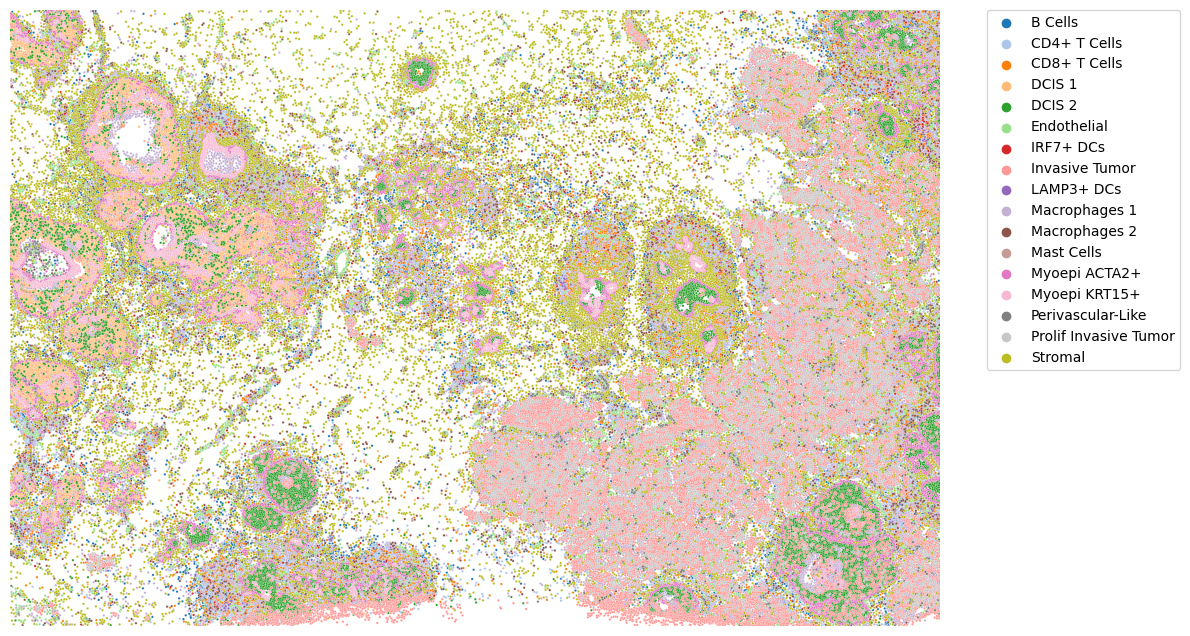

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# reset style
plt.style.use('default')
plt.figure(figsize=(12, 8))
plt.ylim(0, gene_map.shape[0])
plt.xlim(gene_map.shape[1], 0)
# Sorted by cell type
annotated_adata_st = ad_st
plot_df = pd.DataFrame(annotated_adata_st.obsm['spatial'], columns=['center_x', 'center_y'])
plot_df['C_scANVI'] = annotated_adata_st.obs['C_portal'].values
plot_df = plot_df.sort_values(by='C_scANVI')
# Selected Endothelial and invasive Tumor / Prolif Invasive Tumor
# plot_df = plot_df[plot_df['C_scANVI'].isin(["DCIS 1", "DCIS 2", "Invasive Tumor", "Prolif Invasive Tumor", "T Cell & Tumor Hybrid", "Myoepi ACTA2+", "Myoepi KRT15+"])]
# Change color
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=3 , palette='tab20')
# Legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# No axis
plt.axis('off')
plt.show()

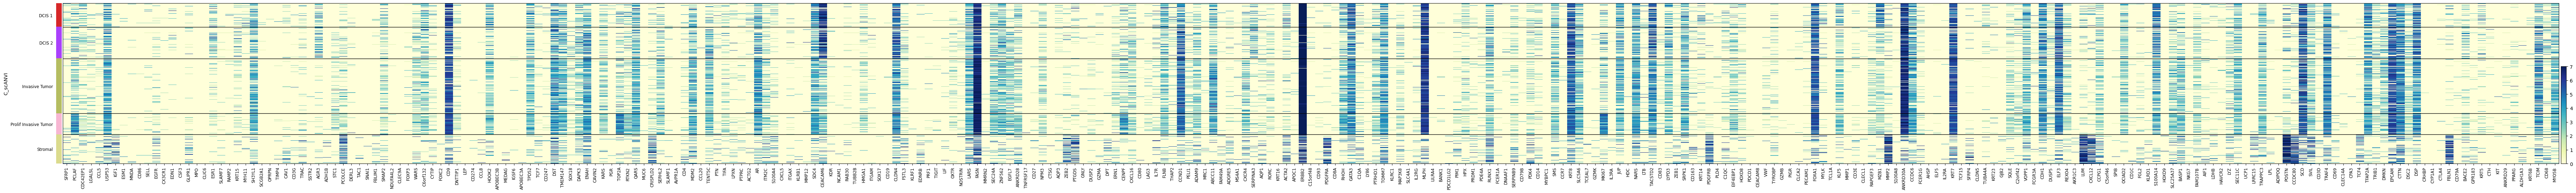

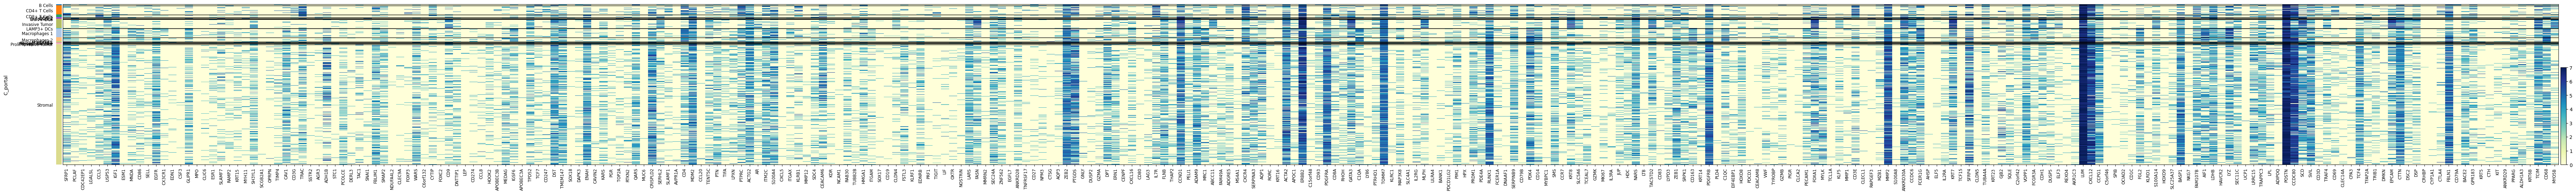

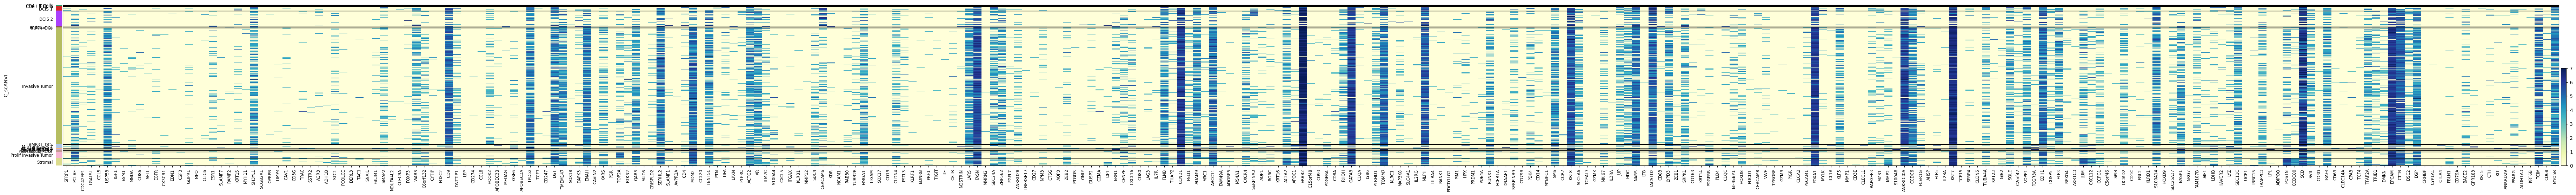

In [20]:
adata = ad_sc.copy()
adata.X = adata.layers["counts"]
gene_list = ad_st.var.index # ["CDH1", "TACSTD2"]
# Only show invasive tumor and Prolif Invasive Tumor
adata = adata[adata.obs["C_scANVI"].isin(["Stromal","Invasive Tumor", "Prolif Invasive Tumor", "DCIS 1", "DCIS 2"])]
sc.pl.heatmap(adata,gene_list, groupby='C_scANVI', cmap='YlGnBu', show_gene_labels=True, vmax=7)

adata = ad_st.copy()
adata.X = adata.layers["counts"]
gene_list = ad_st.var.index # ["CDH1", "TACSTD2"]
# Only show invasive tumor and Prolif Invasive Tumor
adata = adata[adata.obs["C_scANVI"].isin(["Stromal"])]
sc.pl.heatmap(adata,gene_list, groupby='C_portal', cmap='YlGnBu', show_gene_labels=True, vmax=7)

adata = ad_st.copy()
adata.X = adata.layers["counts"]
gene_list =  ad_st.var.index # ["CDH1", "TACSTD2"]
# Only show invasive tumor and Prolif Invasive Tumor
adata = adata[adata.obs["C_portal"].isin(["Invasive Tumor"])]
sc.pl.heatmap(adata,gene_list, groupby='C_scANVI', cmap='YlGnBu', show_gene_labels=True, vmax=7)